# Quick Shake-Shake Net for CIFAR10
*Thomas Viehmann <tv@learnapparat.de>*

Prompted by a discussion on the Pytorch forums, here is a quick implementation of Shake-Shake Net in PyTorch

Reference: [Xavier Gastaldi, Shake-Shake regularization](https://arxiv.org/abs/1705.07485), [original (LUA-Torch) implementation by the author](https://github.com/xgastaldi/shake-shake)

Shortcomings:
- I don't do the cosine learning rate scheduling of the original implementation.
- I am not quite certain whether the original implementation does data augmentation.
- I have not added weight decay and the other usual tricks.
- I only do 80 epochs.
This only gets me 89% accuracy instead of 97% as in the reference.

The key thing is to how to implement the random weighting for forward and backward.
I'm using a trick using `detach` I learned form [a post on Gumbel Softmax to the PyTorch forums by Hugh Perkins](https://discuss.pytorch.org/t/stop-gradients-for-st-gumbel-softmax/530/10).

(I'll add more commentary, but I wanted to share the code.)

In [1]:
import torch
import torchvision
from matplotlib import pyplot
%matplotlib inline
import os
import collections
import IPython
import itertools
import numpy
from torch.autograd import Variable

In [2]:
train_tr = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

test_tr = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])


In [3]:
train_ds = torchvision.datasets.CIFAR10(root='/home/datasets/cifar10/', train=True, download=False, transform=train_tr)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='/home/datasets/cifar10/', train=False, download=False, transform=test_tr)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

In [14]:
# shakeshake net leaning heavily on the original torch implementation https://github.com/xgastaldi/shake-shake/
class ShakeShakeBlock2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride, per_image=True, rand_forward=True, rand_backward=True):
        super().__init__()
        self.same_width = (in_channels==out_channels)
        self.per_image = per_image
        self.rand_forward = rand_forward
        self.rand_backward = rand_backward
        self.stride = stride
        self.net1, self.net2 = [torch.nn.Sequential(
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
                        torch.nn.BatchNorm2d(out_channels),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                        torch.nn.BatchNorm2d(out_channels)) for i in range(2)]
        if not self.same_width:
            self.skip_conv1 = torch.nn.Conv2d(in_channels, out_channels//2, 1)
            self.skip_conv2 = torch.nn.Conv2d(in_channels, out_channels//2, 1)
            self.skip_bn = torch.nn.BatchNorm2d(out_channels)
    def forward(self, inp):
        if self.same_width:
            skip = inp
        else:
            # double check, this seems to be a fancy way to trow away the top-right and bottom-left of each 2x2 patch (with stride=2)
            x1 = torch.nn.functional.avg_pool2d(inp, 1, stride=self.stride)
            x1 = self.skip_conv1(x1)
            x2 = torch.nn.functional.pad(inp, (1,-1,1,-1))            # this makes the top and leftmost row 0. one could use -1,1
            x2 = torch.nn.functional.avg_pool2d(x2, 1, stride=self.stride)
            x2 = self.skip_conv2(x2)
            skip = torch.cat((x1,x2), dim=1)
            skip = self.skip_bn(skip)
        x1 = self.net1(inp)
        x2 = self.net2(inp)

        if self.training:
            if self.rand_forward:
                if self.per_image:
                    alpha = Variable(inp.data.new(inp.size(0),1,1,1).uniform_())
                else:
                    alpha = Variable(inp.data.new(1,1,1,1).uniform_())
            else:
                alpha = 0.5
            if self.rand_backward:
                if self.per_image:
                    beta = Variable(inp.data.new(inp.size(0),1,1,1).uniform_())
                else:
                    beta = Variable(inp.data.new(1,1,1,1).uniform_())
            else:
                beta = 0.5
            # this is the trick to get beta in the backward (because it does not see the detatched)
            # and alpha in the forward (when it sees the detached with the alpha and the beta cancel)
            x = skip+beta*x1+(1-beta)*x2+((alpha-beta)*x1).detach()+((beta-alpha)*x2).detach()
        else:
            x = skip+0.5*(x1+x2)
        return x

            
class ShakeShakeBlocks2d(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, depth, stride, per_image=True, rand_forward=True, rand_backward=True):
        super().__init__(*[
            ShakeShakeBlock2d(in_channels if i==0 else out_channels, out_channels, stride if i==0 else 1,
                              per_image, rand_forward, rand_backward) for i in range(depth)])

class ShakeShakeNet(torch.nn.Module):
    def __init__(self, depth=20, basewidth=32, per_image=True, rand_forward=True, rand_backward=True, num_classes=16):
        super().__init__()
        assert (depth - 2) % 6==0, "depth should be n*6+2"
        n = (depth - 2) // 6
        self.inconv = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.s1 = ShakeShakeBlocks2d(16, basewidth, n, 1, per_image, rand_forward, rand_backward)
        self.s2 = ShakeShakeBlocks2d(basewidth, 2*basewidth, n, 2, per_image, rand_forward, rand_backward)
        self.s3 = ShakeShakeBlocks2d(2*basewidth, 4*basewidth, n, 2, per_image, rand_forward, rand_backward)
        self.fc = torch.nn.Linear(4*basewidth, num_classes)
    def forward(self, x):
        x = self.inconv(x)
        x = self.bn1(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = torch.nn.functional.relu(x)
        x = x.view(x.size(0), x.size(1), -1).mean(2)
        x = self.fc(x)
        return x



In [15]:
model = ShakeShakeNet()
model.cuda()

ShakeShakeNet(
  (inconv): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (s1): ShakeShakeBlocks2d(
    (0): ShakeShakeBlock2d(
      (net1): Sequential(
        (0): ReLU()
        (1): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (3): ReLU()
        (4): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      )
      (net2): Sequential(
        (0): ReLU()
        (1): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (3): ReLU()
        (4): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      )
      (skip_conv1): Conv2d (16, 16, kernel_size=(1, 

In [16]:
opt = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9)

In [17]:
losses = []
corrects = []
last_corrects = 0

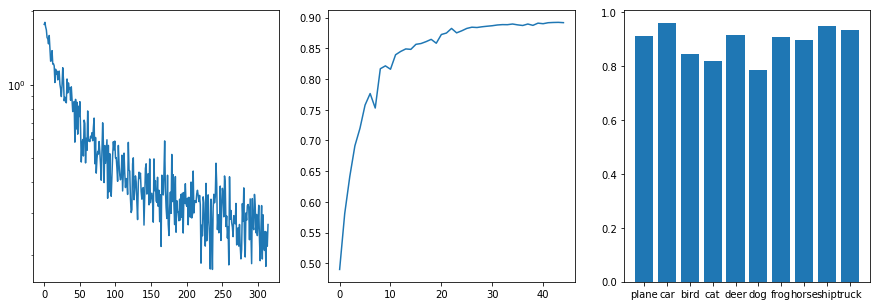

val 8920.0 10000 0.892 max 0.8925
lr 0.00625
45 49 391 0.1902163326740265
45 99 391 0.32871001958847046
45 149 391 0.2733481824398041


In [ ]:
for epoch in range(80):
    model.train()
    print ("lr",opt.param_groups[0]['lr'])
    if opt.param_groups[0]['lr']<1e-6:
        print ("lr below 1e-5, exit")
        break
    for i,(data, target) in enumerate(train_dl):
        data = torch.autograd.Variable(data.cuda())
        target = torch.autograd.Variable(target.cuda())
        opt.zero_grad()
        pred = model(data)
        loss = torch.nn.functional.cross_entropy(pred, target)
        loss.backward()
        opt.step()
        if i % 50 == 49:
            print (epoch,i, len(train_dl), loss.data[0])
            losses.append(loss.data[0])
    model.eval()
    totalcorrect = 0
    total = 0
    corrects_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)
    for i,(data, target) in enumerate(test_dl):
        data = torch.autograd.Variable(data.cuda())
        pred = model(data).max(1)[1].data.cpu()
        correct = (target==pred).float()
        corrects_per_class += torch.sparse.FloatTensor(target.view(1,-1), correct, torch.Size((num_classes,))).to_dense()
        total_per_class += torch.sparse.FloatTensor(target.view(1,-1), torch.ones(target.size(0)), torch.Size((num_classes,))).to_dense()
        totalcorrect += correct.sum()
        total += target.size(0)
        if i%50==0: print(i, len(test_dl))
    corrects.append(totalcorrect/len(test_ds))
    if corrects[-1] < last_corrects*0.995:
        model.load_state_dict(last_state)
        for pg in opt.param_groups:
            pg['lr'] /= 2
    elif corrects[-1] > last_corrects:
        last_corrects = max(corrects)
        last_state = collections.OrderedDict([(k,v.cpu()) for k,v in model.state_dict().items()])
    IPython.display.clear_output(True)
    pyplot.figure(figsize=(15,5))
    pyplot.subplot(1,3,1)
    pyplot.plot(losses)
    pyplot.yscale('log')
    pyplot.subplot(1,3,2)
    pyplot.plot(corrects)
    pyplot.subplot(1,3,3)
    bars = pyplot.bar(torch.arange(0,num_classes),corrects_per_class/total_per_class)
    pyplot.xticks(numpy.arange(num_classes))
    pyplot.gca().set_xticklabels(classes)
    pyplot.show()
    print ("val",totalcorrect,len(test_ds),totalcorrect/len(test_ds), "max", max(corrects))
model.load_state_dict(last_state)
print ("max correct",max(corrects))

If you find bugs or have suggestions or this is useful to you, I appreciate your feedback.

Thomas Viehmann, <tv@lernapparat.de>